In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
import datetime
import time
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import linear_model
from sklearn.metrics import r2_score

import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import os

from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU


from sklearn.metrics import mean_absolute_error  # MSE
from IPython.display import Image 

plt.rcParams['font.sans-serif']=['SimHei']#显示中文标签 
plt.rcParams['axes.unicode_minus']=False
%matplotlib inline
# %matplotlib notebook  
#交互式

In [2]:
# tf.random.set_seed(1234)   # 把随机种子设置为一个定值  可以实现实验的可复现性

In [3]:
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]'

In [4]:
# pip list

In [5]:
# conda list

In [6]:
# print(tf.__version__)
# print(tf.__path__)

In [7]:
df1=pd.read_excel('E:/NSCA/sca_extend.xls')    # header =0  是去掉表头的 
df1.drop(columns=['SCA_NA','SCA_EA'], axis=1, inplace=True)
df1

,date,SCA_NH
0,2000-03-01T00:00:00,4.876570e+07
1,2000-04-01T00:00:00,4.278664e+07
2,2000-05-01T00:00:00,3.106701e+07
3,2000-06-01T00:00:00,1.514596e+07
4,2000-07-01T00:00:00,7.582371e+06
...,...,...
259,2021-10-01T00:00:00,2.328566e+07
260,2021-11-01T00:00:00,2.967021e+07
261,2021-12-01T00:00:00,2.482112e+07
262,2022-01-01T00:00:00,3.667615e+07


In [8]:
df1.dtypes

date       object
SCA_NH    float64
dtype: object

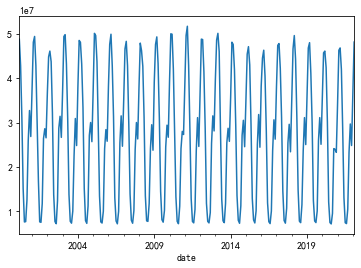

In [9]:
df1.set_index('date',inplace=True)  # 日期变为索引就不是字段了
df1.index=pd.to_datetime(df1.index)

#drop null values
df1.dropna(inplace=True)
df1['SCA_NH'].plot()


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


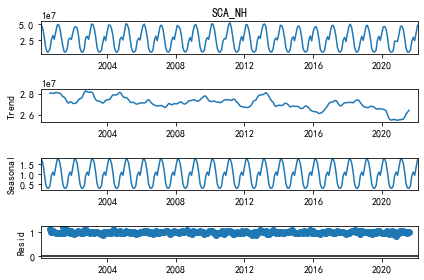

In [10]:
# 下面深入分解：长期趋势Trend、季节性seasonality和随机残差residuals。

# 强行补充小知识：平稳性处理之“分解”
# 所谓分解就是将时序数据分离成不同的成分。statsmodels使用的X-11分解过程，它主要将时序数据分离成长期趋势、季节趋势和随机成分。
# 与其它统计软件一样，statsmodels也支持两类分解模型，加法模型和乘法模型，model的参数设置为"additive"（加法模型）和"multiplicative"（乘法模型）。

import statsmodels.api as sm  # 导入统计建模模块
# multiplicative
res = sm.tsa.seasonal_decompose(df1['SCA_NH'],freq=12,model="multiplicative") 
# 这里用到的.tsa.seasonal_decompose()函数，经尝试：参数ts.values时，横坐标是Time；参数ts时，横坐标是date_block_num。其他不变。
# freg这个参数容后研究，这里暂且猜测是周期12个月。

# plt.figure(figsize=(16,12))
fig = res.plot()

# 乘法好一点

date
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
2000-06-01   NaN
2000-07-01   NaN
              ..
2021-10-01   NaN
2021-11-01   NaN
2021-12-01   NaN
2022-01-01   NaN
2022-02-01   NaN
Name: trend, Length: 264, dtype: float64

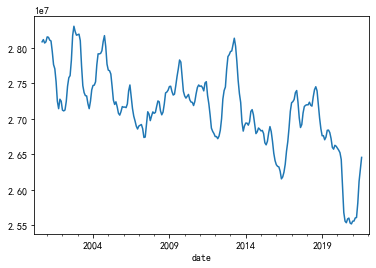

In [11]:
#分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来:
from statsmodels.tsa.seasonal import seasonal_decompose
# def decompose(timeseries):
# fig=plt.figure(figsize=(6,4),dpi=600)
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
decomposition = seasonal_decompose(df1['SCA_NH'],period=12,model="multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# 能不能分离出来  分别计算
trend.plot()
trend

date
2000-03-01    1.783154
2000-04-01    1.575844
2000-05-01    1.106761
2000-06-01    0.497749
2000-07-01    0.286684
                ...   
2021-10-01    0.921893
2021-11-01    1.104831
2021-12-01    0.938785
2022-01-01    1.366567
2022-02-01    1.751196
Name: seasonal, Length: 264, dtype: float64

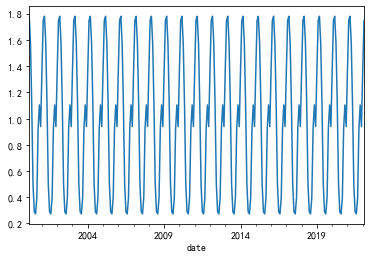

In [12]:
seasonal.plot()
seasonal

date
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
2000-06-01   NaN
2000-07-01   NaN
              ..
2021-10-01   NaN
2021-11-01   NaN
2021-12-01   NaN
2022-01-01   NaN
2022-02-01   NaN
Name: resid, Length: 264, dtype: float64

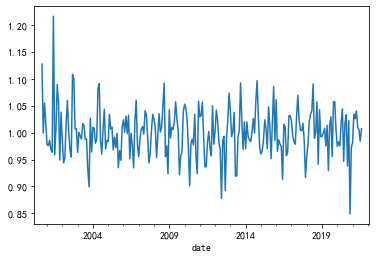

In [13]:
residual.plot()
residual

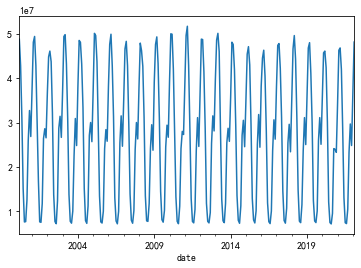

In [14]:
df1['SCA_NH'].plot()  #  目前264  2000-03-01 2022-02-01 

In [15]:
df1.iloc[0:10]

,SCA_NH
date,
2000-03-01,4.876570e+07
2000-04-01,4.278664e+07
2000-05-01,3.106701e+07
2000-06-01,1.514596e+07
2000-07-01,7.582371e+06
2000-08-01,7.666192e+06
2000-09-01,1.252402e+07
2000-10-01,2.590000e+07
2000-11-01,3.270000e+07


In [16]:
df=df1
df['trend']=trend
df['seasonal']=seasonal
df['residual']=residual
df['label']=df['SCA_NH']

In [17]:
df.dropna(inplace=True)
df #252       也就是 trend 前后会各去掉6项  这是因为STL的原因

,SCA_NH,trend,seasonal,residual,label
date,,,,,
2000-09-01,1.252402e+07,2.808346e+07,0.395757,1.126846,1.252402e+07
2000-10-01,2.590000e+07,2.811462e+07,0.921893,0.999279,2.590000e+07
2000-11-01,3.270000e+07,2.806655e+07,1.104831,1.054540,3.270000e+07
2000-12-01,2.684653e+07,2.808263e+07,0.938785,1.018320,2.684653e+07
2001-01-01,3.760000e+07,2.815290e+07,1.366567,0.977313,3.760000e+07
...,...,...,...,...,...
2021-04-01,4.196970e+07,2.560851e+07,1.575844,1.040012,4.196970e+07
2021-05-01,2.884196e+07,2.581218e+07,1.106761,1.009593,2.884196e+07
2021-06-01,1.307233e+07,2.611483e+07,0.497749,1.005670,1.307233e+07


In [18]:
df.iloc[0:10]

,SCA_NH,trend,seasonal,residual,label
date,,,,,
2000-09-01,1.252402e+07,2.808346e+07,0.395757,1.126846,1.252402e+07
2000-10-01,2.590000e+07,2.811462e+07,0.921893,0.999279,2.590000e+07
2000-11-01,3.270000e+07,2.806655e+07,1.104831,1.054540,3.270000e+07
2000-12-01,2.684653e+07,2.808263e+07,0.938785,1.018320,2.684653e+07
2001-01-01,3.760000e+07,2.815290e+07,1.366567,0.977313,3.760000e+07
2001-02-01,4.810000e+07,2.814726e+07,1.751196,0.975830,4.810000e+07
2001-03-01,4.940000e+07,2.810759e+07,1.783154,0.985631,4.940000e+07
2001-04-01,4.290000e+07,2.809578e+07,1.575844,0.968953,4.290000e+07
2001-05-01,2.980000e+07,2.794578e+07,1.106761,0.963488,2.980000e+07


# mem_pre_days

mem_days =3
pre_days =2


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# sca_X = scaler.fit_transform(df.iloc[:,1:-1].values)  # 3个分量
# sca_X = scaler.fit_transform(df.iloc[:,:1].values)  #单变量
# sca_X = scaler.fit_transform(df)  #全部标准化了     # 4个分量  这个基本pass


# print('sca_X',sca_X.shape)
# sca_X

df['SCA_NH'] = scaler.fit_transform(df['SCA_NH'].values.reshape(-1, 1))
df['trend'] = scaler.fit_transform(df['trend'].values.reshape(-1, 1))
df['seasonal'] = scaler.fit_transform(df['seasonal'].values.reshape(-1, 1))
df['residual'] = scaler.fit_transform(df['residual'].values.reshape(-1, 1))

# df['label'] = scaler.fit_transform(df.iloc[:,-1:].values.reshape(-1, 1)) 

df

sca_X=df.iloc[:,:1].values
sca_X

# 必须先归一化 再移动label  要不会因为后面的dropna导致归一化后SCA和label的值不对应

df.sort_index(inplace=True)
df['label'] = df['label'].shift(-pre_days) #其实问题是出现在这的 如果是单变量的话 也要将y平移 出个label 吗

df 

df.dropna(inplace=True)
df # 在252 基础上再减去pre_days 的结果

dft=df[mem_days-1:-pre_days] # 这个是为了的时间y统一的 搞了个副本

from collections import deque
deq = deque(maxlen=mem_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_days:
        X.append(list(deq))

X_lately = X[-pre_days:]  
X = X[:-(pre_days+mem_days-1)]

y = df['label'].values[mem_days-1:-pre_days]

import numpy as np
X = np.array(X)
y = np.array(y)
print('X',X.shape,'len(X)',len(X))
print('y',y.shape,'len(y)',len(y))
# print('len(X_lately)  其实这个是预测pre_days的长度',len(X_lately))
print('X[0]',X[0])
print('X[1]',X[1])
print('y[0]',y[0])
print('y[1]',y[1])


print('x',X)
print('y',y)


lstm_layers = [3]
dense_layers = [2]
units = [64]
the_units=32

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

print('X_train',X_train.shape,'X_test',X_test.shape, 'y_train',y_train.shape,'y_test',y_test.shape)

print('X_train',X_train)
print('y_train',y_train)
print('X_test',X_test)
print('y_test',y_test)
# 这个训练集和测试集并没有打散\ # 这个训练集和测试集并没有打散\ 
# 那就是在测试集上泛化误差 最小呗  那就是test 
# 但是你是拿着test来优化参数的 时间长了test也变得开卷了 信息泄露 没有意义了
#这些小测试也就是要说的验证集。我们通过验证集来作为调整模型的依据，这样不至于将测试集中的信息泄露

# 也就是说我们将数据划分训练集、验证集和测试集。在训练集上训练模型，在验证集上评估模型，一旦找到的最佳的参数，
# 就在测试集上最后测试一次，测试集上的误差作为泛化误差的近似。关于验证集的划分可以参考测试集的划分
#其实可以忽略validation的意思 因为这个也是作为调参的依据 我已经调完参数了  就是在test 上最后预测了一次
#测试集 仅仅一次使用 为了评估最终模型泛化能力
# 按照验证集的效果，来选超参数            
# 训练 验证 测试  作业 模考 期末考试
# 交叉验证法 交叉验证法的作用就是尝试利用不同的训练集/测试集划分来对模型做多组不同的训练/测试

In [19]:
import os
os.environ['KERAS_BACKEND']='tensorflow'

In [20]:
# R^2
from tensorflow import keras
from keras import backend as K
def RSquared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#进行除法运算时，通常将其添加到分母中以防止被零除误差。Epsilon是一个很小的值，与分母的值几乎没有区别，但可确保它不等于零。


# # wmape
# def wmape(y_true, y_pred):
#     SS_res =  K.sum(K.abs(y_true - y_pred)) 
#     SS_tot = K.sum(y_true)
#     return SS_res/SS_tot



def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it
    # make a series called mape
    se_mape = abs(actual-forecast)/actual
    # get a float of the sum of the actual
    ft_actual_sum = K.sum(actual)
    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape
    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = K.sum(se_actual_prod_mape)
    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    # return a float
    return ft_wmape_forecast


Using TensorFlow backend.


In [21]:
pre_days =[1]

mem_days = [6]
lstm_layers = [3]
dense_layers = [2]
units = [128]

In [22]:
def Stock_Price_LSTM_Data_Precesing(df,mem_days,pre_days):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
#     df['SCA_NH'] = scaler.fit_transform(df['SCA_NH'].values.reshape(-1, 1))
    df['trend'] = scaler.fit_transform(df['trend'].values.reshape(-1, 1))
    df['seasonal'] = scaler.fit_transform(df['seasonal'].values.reshape(-1, 1))
    df['residual'] = scaler.fit_transform(df['residual'].values.reshape(-1, 1))
    
    sca_X=df.iloc[:,1:-1].values

    df.sort_index(inplace=True)
    df['label'] = df['label'].shift(-pre_days) #其实问题是出现在这的 如果是单变量的话 也要将y平移 出个label 吗
#     df.dropna(inplace=True)    如果是在循环中用和这个的话 会导致df的快速减小
    
    dft=df[mem_days-1:-pre_days] # 这个是为了的时间y统一的 搞了个副本
    
    
    from collections import deque
    deq = deque(maxlen=mem_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]  
    X = X[:-pre_days]

    y = df['label'].values[mem_days-1:-pre_days]

    import numpy as np 
    X = np.array(X)
    y = np.array(y)
    print('X',X.shape,'len(X)',len(X))
    print('y',y.shape,'len(y)',len(y))
    # print('len(X_lately)  其实这个是预测pre_days的长度',len(X_lately))

#     print('X[0]',X[0])
#     print('X[1]',X[1])
#     print('y[0]',y[0])
#     print('y[1]',y[1])


#     print('x',X)
#     print('y',y)
    return X,y

In [23]:

from keras import optimizers
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                for the_pre_days in pre_days:
                    

                    filepath = 'F:/model-3var/mem6/{val_mape:.2f}_{epoch:02d}_'+f'mem_{the_mem_days}_pre_{the_pre_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                    print('memdays',the_mem_days,'pre_days',the_pre_days,'lstm_layers',the_lstm_layers,'the_dense_layers',the_dense_layers,'the_units',the_units)
                          
                    checkpoint = ModelCheckpoint(
                        filepath=filepath,
                        save_weights_only=True,
                        monitor='val_mape',
                        mode='min',
                        save_best_only=True)

                    #X_train中间这个也叫作TIME_STEPS 步长 也就是mem_days   
                    #GRU LSTM 必须要输入3D 张量

                    X,y = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,the_pre_days)

                    from sklearn.model_selection import train_test_split
                    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                    
                    print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)    
                    dft=df[the_mem_days-1:-the_pre_days] # 这个是为了的时间y统一的 搞了个副本
                    

                    model_l = Sequential()
                    model_l.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                    model_l.add(Dropout(0.2))

                    for i in range(the_lstm_layers):
                        model_l.add(LSTM(the_units,activation='relu',return_sequences=True))
                        model_l.add(Dropout(0.2))

                    model_l.add(LSTM(the_units,activation='relu'))
                    model_l.add(Dropout(0.2))

                    for i in range(the_dense_layers):
                        model_l.add(Dense(the_units,activation='relu'))
                        model_l.add(Dropout(0.2))

                    model_l.add(Dense(1))


                    adam = keras.optimizers.Adam(lr=0.008)

                    model_l.compile(optimizer=adam,
                                 loss='mean_squared_error',
                                 metrics=[ 'mae', 'mape',RSquared])#   相当于编译  也要选择RSquared 不过得自己定义函数

                    history_l=model_l.fit(X_train,y_train,batch_size=30,verbose=2,epochs=300,validation_data=(X_test,y_test) ,shuffle = False,callbacks=[checkpoint])
                    #                 


memdays 6 pre_days 1 lstm_layers 3 the_dense_layers 2 the_units 128
X (246, 6, 3) len(X) 246
y (246,) len(y) 246
(221, 6, 3) (25, 6, 3) (221,) (25,)
Train on 221 samples, validate on 25 samples
Epoch 1/300
221/221 - 8s - loss: 947843416679030.2500 - mae: 27190758.0000 - mape: 99.6656 - RSquared: -3.6342e+00 - val_loss: 567054264434688.0000 - val_mae: 19772400.0000 - val_mape: 70.6731 - val_RSquared: -1.8343e+00
Epoch 2/300
221/221 - 1s - loss: 436905817987526.0625 - mae: 16069117.0000 - mape: 59.0720 - RSquared: -1.1359e+00 - val_loss: 191351312351232.0000 - val_mae: 11367334.0000 - val_mape: 53.9943 - val_RSquared: 0.0436
Epoch 3/300
221/221 - 0s - loss: 248225265185453.7500 - mae: 12090009.0000 - mape: 45.8541 - RSquared: -2.8502e-01 - val_loss: 529696068468736.0000 - val_mae: 17812154.0000 - val_mape: 109.3062 - val_RSquared: -1.6475e+00
Epoch 4/300
221/221 - 0s - loss: 221140007957091.6250 - mae: 11967130.0000 - mape: 57.3872 - RSquared: -1.0446e-01 - val_loss: 357469188521984.0000

Epoch 40/300
221/221 - 0s - loss: 41154654526635.4375 - mae: 4734976.5000 - mape: 18.0726 - RSquared: 0.8081 - val_loss: 16111085027328.0000 - val_mae: 2892709.0000 - val_mape: 11.9428 - val_RSquared: 0.9195
Epoch 41/300
221/221 - 0s - loss: 27483873641485.9023 - mae: 3825020.5000 - mape: 14.5724 - RSquared: 0.8713 - val_loss: 15156442562560.0000 - val_mae: 2996015.2500 - val_mape: 13.3116 - val_RSquared: 0.9242
Epoch 42/300
221/221 - 0s - loss: 26110237487270.8047 - mae: 3643305.7500 - mape: 14.1651 - RSquared: 0.8436 - val_loss: 101217162231808.0000 - val_mae: 8216802.5000 - val_mape: 31.4436 - val_RSquared: 0.4941
Epoch 43/300
221/221 - 0s - loss: 58478770218776.3281 - mae: 5869217.0000 - mape: 22.3834 - RSquared: 0.7356 - val_loss: 46905014878208.0000 - val_mae: 4599293.0000 - val_mape: 15.0461 - val_RSquared: 0.7656
Epoch 44/300
221/221 - 0s - loss: 30345004829960.1094 - mae: 4110343.7500 - mape: 15.1009 - RSquared: 0.8498 - val_loss: 19419333918720.0000 - val_mae: 2935953.5000 - 

Epoch 80/300
221/221 - 0s - loss: 33361285505950.6992 - mae: 4266960.0000 - mape: 15.3614 - RSquared: 0.8289 - val_loss: 20388614504448.0000 - val_mae: 3483245.0000 - val_mape: 12.7497 - val_RSquared: 0.8981
Epoch 81/300
221/221 - 0s - loss: 24739665091829.5742 - mae: 3676617.0000 - mape: 13.9580 - RSquared: 0.8724 - val_loss: 21604929110016.0000 - val_mae: 3233432.2500 - val_mape: 11.7759 - val_RSquared: 0.8920
Epoch 82/300
221/221 - 0s - loss: 28212092668524.8867 - mae: 4069962.2500 - mape: 15.5806 - RSquared: 0.8538 - val_loss: 24224970309632.0000 - val_mae: 3450502.5000 - val_mape: 11.4434 - val_RSquared: 0.8789
Epoch 83/300
221/221 - 0s - loss: 32325294116548.9219 - mae: 4049558.5000 - mape: 14.7055 - RSquared: 0.8232 - val_loss: 49210720256000.0000 - val_mae: 5429794.5000 - val_mape: 19.5981 - val_RSquared: 0.7540
Epoch 84/300
221/221 - 0s - loss: 58809710122943.1328 - mae: 5833316.0000 - mape: 20.4413 - RSquared: 0.7082 - val_loss: 25776382541824.0000 - val_mae: 3457568.7500 - v

Epoch 120/300
221/221 - 0s - loss: 16304046497532.5254 - mae: 2988692.0000 - mape: 11.9951 - RSquared: 0.9186 - val_loss: 26624019922944.0000 - val_mae: 3536084.7500 - val_mape: 10.9833 - val_RSquared: 0.8669
Epoch 121/300
221/221 - 0s - loss: 28259109492596.9961 - mae: 3642324.0000 - mape: 13.5555 - RSquared: 0.8675 - val_loss: 7346524782592.0000 - val_mae: 1753326.3750 - val_mape: 7.6444 - val_RSquared: 0.9633
Epoch 122/300
221/221 - 0s - loss: 19056081143984.0742 - mae: 3175779.0000 - mape: 12.4567 - RSquared: 0.9057 - val_loss: 16611188670464.0000 - val_mae: 3569412.7500 - val_mape: 15.7596 - val_RSquared: 0.9170
Epoch 123/300
221/221 - 0s - loss: 50481704644033.4453 - mae: 5267248.0000 - mape: 18.2954 - RSquared: 0.7673 - val_loss: 44111390310400.0000 - val_mae: 5254631.0000 - val_mape: 21.4487 - val_RSquared: 0.7795
Epoch 124/300
221/221 - 0s - loss: 46618531085372.2344 - mae: 5000855.0000 - mape: 17.9606 - RSquared: 0.7782 - val_loss: 31987718946816.0000 - val_mae: 4216696.0000 

Epoch 160/300
221/221 - 0s - loss: 30433198687913.1211 - mae: 4171890.0000 - mape: 15.1006 - RSquared: 0.8525 - val_loss: 12423045054464.0000 - val_mae: 2032634.3750 - val_mape: 7.4181 - val_RSquared: 0.9379
Epoch 161/300
221/221 - 0s - loss: 17965487436832.4336 - mae: 3036570.0000 - mape: 11.8556 - RSquared: 0.9131 - val_loss: 23923179651072.0000 - val_mae: 3426933.0000 - val_mape: 11.7335 - val_RSquared: 0.8804
Epoch 162/300
221/221 - 0s - loss: 22939759563623.0938 - mae: 3540345.0000 - mape: 13.2248 - RSquared: 0.8884 - val_loss: 13881502072832.0000 - val_mae: 2445089.5000 - val_mape: 9.4088 - val_RSquared: 0.9306
Epoch 163/300
221/221 - 0s - loss: 22926229697346.0273 - mae: 3407529.5000 - mape: 12.4912 - RSquared: 0.8948 - val_loss: 13067808145408.0000 - val_mae: 2698148.2500 - val_mape: 9.4057 - val_RSquared: 0.9347
Epoch 164/300
221/221 - 0s - loss: 21622938516688.5078 - mae: 3426266.2500 - mape: 12.8536 - RSquared: 0.8986 - val_loss: 15153475092480.0000 - val_mae: 2536771.2500 -

Epoch 200/300
221/221 - 0s - loss: 19461771108463.2031 - mae: 3150892.0000 - mape: 12.7710 - RSquared: 0.9003 - val_loss: 23606413230080.0000 - val_mae: 3540937.0000 - val_mape: 11.4599 - val_RSquared: 0.8820
Epoch 201/300
221/221 - 0s - loss: 22095814536493.1758 - mae: 3452647.0000 - mape: 13.2282 - RSquared: 0.8769 - val_loss: 9798125879296.0000 - val_mae: 2360574.0000 - val_mape: 9.3051 - val_RSquared: 0.9510
Epoch 202/300
221/221 - 0s - loss: 22071598712859.8008 - mae: 3303630.0000 - mape: 12.7179 - RSquared: 0.8835 - val_loss: 12118407512064.0000 - val_mae: 2046834.2500 - val_mape: 7.3835 - val_RSquared: 0.9394
Epoch 203/300
221/221 - 0s - loss: 23041828852953.7773 - mae: 3414328.0000 - mape: 12.7823 - RSquared: 0.8775 - val_loss: 53931862392832.0000 - val_mae: 5771443.0000 - val_mape: 20.3721 - val_RSquared: 0.7304
Epoch 204/300
221/221 - 0s - loss: 35901805235389.9766 - mae: 4355748.0000 - mape: 15.2736 - RSquared: 0.8219 - val_loss: 13233575428096.0000 - val_mae: 2943771.0000 -

Epoch 240/300
221/221 - 0s - loss: 13058404971330.0273 - mae: 2677414.0000 - mape: 10.8664 - RSquared: 0.9356 - val_loss: 18744910807040.0000 - val_mae: 3528741.0000 - val_mape: 13.7065 - val_RSquared: 0.9063
Epoch 241/300
221/221 - 0s - loss: 19682377117714.5352 - mae: 3309370.7500 - mape: 12.5157 - RSquared: 0.9098 - val_loss: 15198531354624.0000 - val_mae: 3076858.2500 - val_mape: 12.7693 - val_RSquared: 0.9240
Epoch 242/300
221/221 - 0s - loss: 22637437115711.7109 - mae: 3473929.5000 - mape: 13.5132 - RSquared: 0.8954 - val_loss: 15746226716672.0000 - val_mae: 2943874.2500 - val_mape: 9.7271 - val_RSquared: 0.9213
Epoch 243/300
221/221 - 0s - loss: 18798901003129.6289 - mae: 3033793.5000 - mape: 11.4898 - RSquared: 0.9104 - val_loss: 10269562503168.0000 - val_mae: 1995189.5000 - val_mape: 7.9805 - val_RSquared: 0.9487
Epoch 244/300
221/221 - 0s - loss: 18802734940975.4922 - mae: 3109295.2500 - mape: 12.1669 - RSquared: 0.9146 - val_loss: 4776630681600.0000 - val_mae: 1519161.0000 -

Epoch 280/300
221/221 - 0s - loss: 16509011828550.6602 - mae: 2963101.5000 - mape: 11.0093 - RSquared: 0.9168 - val_loss: 7803287633920.0000 - val_mae: 1743600.3750 - val_mape: 7.8283 - val_RSquared: 0.9610
Epoch 281/300
221/221 - 0s - loss: 16488303524850.0996 - mae: 2972785.0000 - mape: 11.9193 - RSquared: 0.9197 - val_loss: 23220080082944.0000 - val_mae: 3514492.7500 - val_mape: 12.3235 - val_RSquared: 0.8839
Epoch 282/300
221/221 - 0s - loss: 12883941354426.4980 - mae: 2684035.7500 - mape: 10.4507 - RSquared: 0.9386 - val_loss: 18602159767552.0000 - val_mae: 2827108.2500 - val_mape: 10.8975 - val_RSquared: 0.9070
Epoch 283/300
221/221 - 0s - loss: 31179572323304.8320 - mae: 4009814.5000 - mape: 15.7259 - RSquared: 0.8480 - val_loss: 14848277610496.0000 - val_mae: 2752483.7500 - val_mape: 9.3164 - val_RSquared: 0.9258
Epoch 284/300
221/221 - 0s - loss: 24235317240067.4727 - mae: 3587616.2500 - mape: 13.7672 - RSquared: 0.8856 - val_loss: 11804611706880.0000 - val_mae: 2102842.7500 -

In [24]:
# from keras import optimizers
# for the_mem_days in mem_days:
#     for the_lstm_layers in lstm_layers:
#         for the_dense_layers in dense_layers:
#             for the_units in units:
#                 for the_pre_days in pre_days:
                    
                    
#                     filepath = 'F:/model-log2/3var/gru/{val_mape:.2f}_{epoch:02d}_'+f'mem_{the_mem_days}_pre_{the_pre_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'

#                     checkpoint = ModelCheckpoint(
#                         filepath=filepath,
#                         save_weights_only=True,
#                         monitor='val_mape',
#                         mode='min',
#                         save_best_only=True)
#                     X,y = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,the_pre_days)

#                     from sklearn.model_selection import train_test_split
#                     X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

#                     #X_train中间这个也叫作TIME_STEPS 步长 也就是mem_days   
#                     #GRU LSTM 必须要输入3D 张量

#                     model_g = Sequential()
#                     model_g.add(GRU(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
#                     model_g.add(Dropout(0.1))

#                     for i in range(the_lstm_layers):
#                         model_g.add(GRU(the_units,activation='relu',return_sequences=True))
#                         model_g.add(Dropout(0.2))

#                     model_g.add(GRU(the_units,activation='relu'))
#                     model_g.add(Dropout(0.2))

#                     for i in range(the_dense_layers):
#                         model_g.add(Dense(the_units,activation='relu'))
#                         model_g.add(Dropout(0.2))

#                     model_g.add(Dense(1))

#                     adam = keras.optimizers.Adam(lr=0.008)

#                     model_g.compile(optimizer='adam',
#                     #                              loss='mse',     #都是选择 了这个mse 大部分    重新自定义loss 是没必要
#                                  loss='mean_squared_error',
#                                  metrics=[ 'mae', 'mape',RSquared])#   相当于编译  也要选择RSquared 不过得自己定义函数

#                     history_g=model_g.fit(X_train,y_train,batch_size=18,verbose=2,epochs=300,validation_data=(X_test,y_test) ,shuffle = False,callbacks=[checkpoint])
#                 #                 

# 训练集epoches

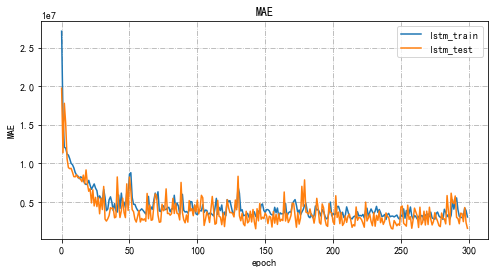

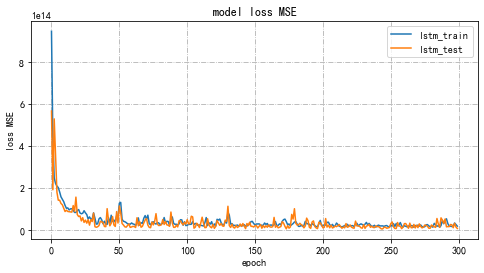

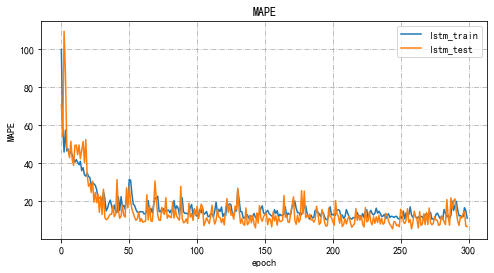

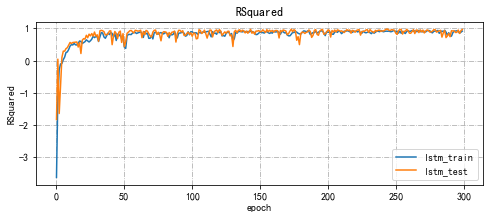

In [25]:
plt.figure(figsize=(8,4))
plt.plot(history_l.history['mae'],label='lstm_train')
plt.plot(history_l.history['val_mae'],label='lstm_test')
# plt.plot(history_g.history['mae'],label='gru_train')
# plt.plot(history_g.history['val_mae'],label='gru_test')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
plt.legend(loc='best')
plt.grid(linestyle='-.')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history_l.history['loss'],label='lstm_train')
plt.plot(history_l.history['val_loss'],label='lstm_test')
# plt.plot(history_g.history['loss'],label='gru_train')
# plt.plot(history_g.history['val_loss'],label='gru_test')
plt.title('model loss MSE')
plt.ylabel('loss MSE')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid(linestyle='-.')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_l.history['mape'],label='lstm_train')
plt.plot(history_l.history['val_mape'],label='lstm_test')
# plt.plot(history_g.history['mape'],label='gru_train')
# plt.plot(history_g.history['val_mape'],label='gru_test')
plt.title('MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
plt.legend(loc='best')
plt.grid(linestyle='-.')
plt.show()



plt.figure(figsize=(8,3))
plt.plot(history_l.history['RSquared'],label='lstm_train')
plt.plot(history_l.history['val_RSquared'],label='lstm_test')
# plt.plot(history_g.history['RSquared'],label='gru_train')
# plt.plot(history_g.history['val_RSquared'],label='gru_test')
plt.title('RSquared')
plt.ylabel('RSquared')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
plt.legend(loc='best')
plt.grid(linestyle='-.')
plt.show()


train loss 不断下降，test loss不断下降，说明网络仍在学习;
train loss 不断下降，test loss趋于不变，说明网络过拟合;
train loss 趋于不变，test loss不断下降，说明数据集100%有问题;
train loss 趋于不变，test loss趋于不变，说明学习遇到瓶颈，需要减小学习率或批量数目;
train loss 不断上升，test loss不断上升，说明网络结构设计不当，训练超参数设置不当，数据集经过清洗等问题。


训练loss还在快速下降而测试的loss下降开始变缓慢出现拐点时候，就可以停止训练

In [26]:
model_l.summary()
# model_g.summary()
#第一层默认的LSTM层 的输入维度就是特征量的4

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 128)            67584     
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 128)            1

In [27]:
#MSE  RMSE  MAE MAPE
import math
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('X_train MSE MAE MAPE R2',trainScore)
    print('Train Score: %.5f MSE (%.2f RMSE)  ' % (trainScore[0], math.sqrt(trainScore[0])))
    
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('X_test MSE MAE MAPE R2',testScore)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

model_score(model_l, X_train, y_train , X_test, y_test)
print("====================================")

# model_score(model_g, X_train, y_train , X_test, y_test)


#  返回值就是loss=mean_squared_error', metrics=[ 'mae', 'mape',Rsquare]

X_train MSE MAE MAPE R2 [1596343038267.077, 962049.75, 4.329802, 0.9923131]
Train Score: 1596343038267.07690 MSE (1263464.70 RMSE)  
X_test MSE MAE MAPE R2 [6738260525056.0, 1526818.4, 6.762223, 0.96632075]
Test Score: 6738260525056.00000 MSE (2595815.97 RMSE)


In [28]:
print('X_train',X_train.shape,'X_test',X_test.shape, 'y_train',y_train.shape,'y_test',y_test.shape)
print(X_train[0])
# print(X_train)
# print('X_test',X_test)
# print('y_test',y_test)

X_train (221, 6, 3) X_test (25, 6, 3) y_train (221,) y_test (25,)
[[ 1.63532919 -1.14639416  2.86089332]
 [ 1.68927739 -0.14818691 -0.01784588]
 [ 1.60603533  0.19888877  1.22919718]
 [ 1.63388536 -0.11614027  0.41184258]
 [ 1.75557754  0.69546528 -0.51354433]
 [ 1.74581447  1.42519967 -0.54702311]]


# lstm测试集预测

In [29]:

# y_test = scaler.inverse_transform(y_test) 

In [30]:
model_l.evaluate(X_test,y_test)   
y_pre_test_l = model_l.predict(X_test, verbose=0)    #得到预测值  这个也能计算MSE
# y_pre_test_l = scaler.inverse_transform(y_pre_test_l) #用作反归一化的

print('predict',y_pre_test_l.shape)

print(y_test)
print(y_pre_test_l)




25/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 560us/sample - loss: 6738260525056.0000 - mae: 1526818.3750 - mape: 6.7622 - RSquared: 0.9663
predict (25, 1)
[ 7445660.4794     10056952.201      25900000.         31100000.
 25091191.8        35400000.         45700000.         4610000

# gru测试集预测

In [31]:

# # 这里不应该有偏移的啊 不不用搞时间偏移 的啊  可以对上的感觉。 因为y是label  预测的也是label 是一个东西啊
# #所以取消使用# df_time = df.index[-len(y_pre_test):]   相应的取消plt.plot(df_time,)


# plt.figure(figsize=(6,4))
# plt.plot(y_test,color='red',label='true')
# plt.plot(y_pre_test_l,color='green',label='predict')
# plt.xlabel("时间")
# plt.ylabel("积雪面积数据")
# plt.legend(loc='best')
# plt.grid(True)
# # plt.savefig('result3-3.png')
# plt.show()

# # /////////////////////////////////////////////////////

# model_g.evaluate(X_test,y_test)
# y_pre_test_g = model_g.predict(X_test, verbose=0)    #得到预测值  这个也能计算MSE
# y_pre_test_g = scaler.inverse_transform(y_pre_test_g) #用作反归一化的

# print('predict',y_pre_test_g.shape)
# print(y_pre_test_g)



# plt.figure(figsize=(6,4))
# # df_time = df.index[-len(y_pre_test):] #这是转化为同一时间 但是这里不应该使用df
# plt.plot(y_test,color='red',label='true')
# plt.plot(y_pre_test_g,color='green',label='predict')
# plt.xlabel("时间")
# plt.ylabel("积雪面积数据")
# plt.legend(loc='best')
# plt.grid(True)
# # plt.savefig('result3-3.png')
# plt.show()



In [32]:
# RMSE R2  ACC 
# 是计算归一化前还是后的呢

print('y_test',y_test.shape)
print(y_test)
print('y_pre_test_l',y_pre_test_l.shape)
print(y_pre_test_l)
# print('y_pre_test_g',y_pre_test_g.shape)
# print(y_pre_test_g)

def rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true)))
    
lstm_rmse=rmse(y_pre_test_l,y_test)
# gru_rmse=rmse(y_pre_test_g,y_test)
print('lstm_rmse',lstm_rmse)
# print('gru_rmse',gru_rmse)

    
l_r2 = r2_score(y_test,y_pre_test_l)
# g_r2 = r2_score(y_test,y_pre_test_g)
print('l_r2',l_r2)
# print('g_r2',g_r2)

# #ACC
# error = 0
# summery = 0
# for i in range(23):
#     error += abs(y_pre_test[i] - y_test[i])
#     summery += y_test[i]
# acc = 1 - error/summery
# print('acc',acc)

y_test (25,)
[ 7445660.4794     10056952.201      25900000.         31100000.
 25091191.8        35400000.         45700000.         46100000.
 42400000.         30100000.         12097891.211       7450972.289
  7143292.4685      9500095.199      24116892.9992699  23950888.90098245
 23276772.9020924  34288769.6612648  46281340.3971747  46813376.7340057
 41969700.0500564  28841960.8946647  13072326.00133153  7412322.37857997
  7213763.972919  ]
y_pre_test_l (25, 1)
[[ 7989504. ]
 [10628748. ]
 [24944868. ]
 [30895510. ]
 [24817824. ]
 [35713430. ]
 [44601576. ]
 [47779564. ]
 [42432600. ]
 [31023128. ]
 [13494515. ]
 [ 8118150.5]
 [ 7954123.5]
 [10442148. ]
 [22893952. ]
 [29222640. ]
 [23350182. ]
 [33470540. ]
 [42671740. ]
 [45266560. ]
 [32070762. ]
 [25184206. ]
 [12895202. ]
 [ 8103385.5]
 [ 8004137. ]]
lstm_rmse 19394965.880665828
l_r2 0.9663207538206566


不同模型在测试集上的R2 RMSE 结果


# 训练集上的预测

In [33]:
model_l.evaluate(X_train,y_train)   #训练集上

y_pre_train = model_l.predict(X_train, verbose=0)    #得到预测值  这个也能计算MSE
# y_pre_train = scaler.inverse_transform(y_pre_train)

print('predict',y_pre_train.shape)
print(y_pre_train)


221/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [34]:
# y = scaler.inverse_transform(y)

In [35]:
df_time = dft.index[0:len(y_pre_train)]
df_time1 = dft.index[len(y_pre_train):]

df_res=dft.index[len(y_pre_train)-1:len(y_pre_train)+1]
# df_time1 = dft.index[:-len(y_pre_test)]  这个没有效果为什么

res=[y_pre_train[-1],y_pre_test_l[0]]

DatetimeIndex(['2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01',
               '2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01',
               '2001-10-01', '2001-11-01',
               ...
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', name='date', length=221, freq=None)
DatetimeIndex(['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01'],
              dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['20

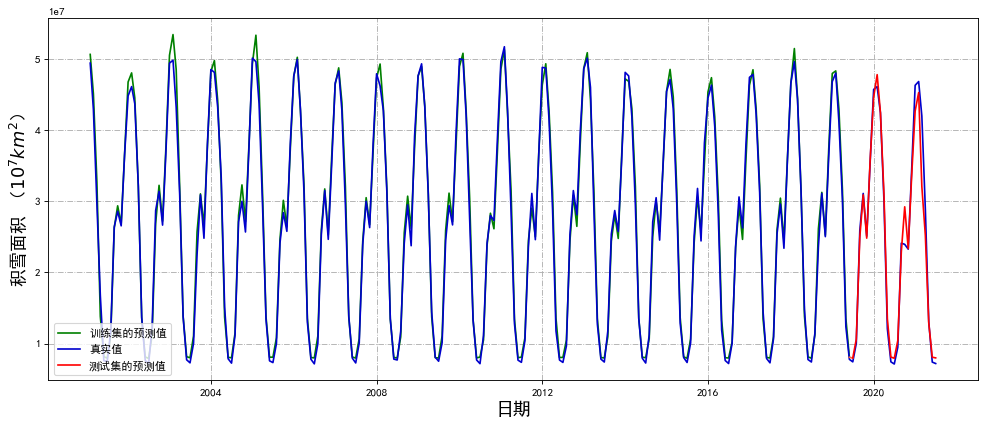

In [74]:
plt.figure(figsize=(15,6),dpi=80, facecolor='w', edgecolor='k')

plt.plot(df_time,y_pre_train, color='green', label='训练集的预测值')
# plt.plot(df_time,y_train, color='blue', label='y_train')


plt.plot(dft.index,y, color='mediumblue', label='真实值')  # 总的


plt.plot(df_res,res, color='tomato',)


plt.plot(df_time1,y_pre_test_l, color='red', label='测试集的预测值')
# plt.plot(df_time1,y_test, color='blue', label='y_test')


font2 = {
'weight' : 'normal',
'size' : 16,
}

plt.xlabel("日期",font2)
plt.ylabel("积雪面积 （$10^7km^2$）",font2)
plt.legend(loc='lower left')
plt.grid(linestyle='-.')
print(df_time)
print(df_time1)
print(df_res)  # 缝补
print(dft.index) #总的
plt.savefig('F:/model_figure/m_res.png',dpi=400)
plt.show()


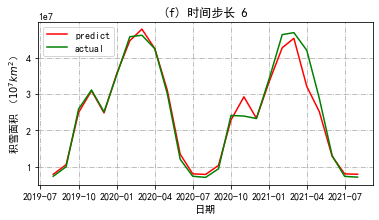

In [37]:
#这是发生偏移的

plt.figure(figsize=(6,3))

df_time2=df.index[-len(y_test):]
plt.plot(df_time2,y_pre_test_l, color='red', label='predict')

plt.plot(df_time2,y_test, color='green', label='actual')
plt.xlabel("日期")
plt.ylabel("积雪面积 （$10^7km^2$）")
plt.legend(loc='best')
plt.grid(linestyle='-.')
# plt.title('日期')
plt.title('(f) 时间步长 6')
plt.savefig('F:/model_figure/m_6_25.png',dpi=400)
plt.show()

In [38]:
# model.evaluate(X_test,y_test)

# actual = scaler.inverse_transform(y_val)[0]
# actual

LSTM 参数 return_sequences=True True LSTM输出为一个序列  默认为false    单层的就为false
input_dim  输入单个样本特征值的维度  我的应该是1个 还是3个
input_length 输入的时间点长度 240个月 240个 这个好像和LSTM 的模型没有关系
其中batch_size是每次梯度更新的样本数，未写明则为32
epochs是指训练模型迭代次数，可以理解为我们遍历了一次所有的模型，则为1次epoch

怀疑MAPE 是将误差累加 所以train的MAPE远小于test 的
MAPE是不对称的，它对负误差（当预测值高于实际值时）要比对正误差施加更大的罚款。
解释如下：对于过低的预测，百分比误差不能超过100％。虽然没有太高的预测上限。因此，MAPE将偏向于预测不足而不是过度预测的模型。
一般认为MAPE小于10时，预测精度较高

建议放一下预测值和真实值的对比曲线。我猜测你的预测结果几乎是真实值的整体延后，如果原曲线还波动很大的话，MAPE必然会极高。

也怀疑是由于要预测的天数太长 导致 差距越大 MAPE就大了
或者是数据由于是月平均 然后数据之间差距太大了？
MAPE 明显是训练集上很差 但是在测试集上还好

首先调差 batch_size lr

lr：float> = 0.学习率
beta_1：float，0 <beta <1。一般接近1。一阶矩估计的指数衰减率
beta_2：float，0 <beta <1。一般接近1。二阶矩估计的指数衰减率
epsilon：float> = 0,模糊因子。如果None，默认为K.epsilon()。该参数是非常小的数，其为了防止在实现中除以零
decay：float> = 0,每次更新时学习率下降

随着学习率的增加，损失会慢慢变小，而后增加，而最佳的学习率就可以从其中损失最小的区域选择。

大的batchsize减少训练时间，提高稳定性

在一定范围内，增加batchsize有助于收敛的稳定性，但是随着batchsize的增加，模型的性能会下降

通常当我们增加batchsize为原来的N倍时，要保证经过同样的样本后更新的权重相等，按照线性缩放规则，学习率应该增加为原来的N倍


[batch size不变的情况下] ,随着学习率的增加，模型也可能会从欠拟合过度到过拟合状态，在大型数据集上的表现尤其明显... 
[在和batch size相适应的学习率范围内]，尽量使用大的学习率，因为很多研究都表明更大的学习率有利于提高泛化能力...


https://zhuanlan.zhihu.com/p/277487038
https://www.zhihu.com/question/32673260/answer/1877223574


训练次数 不限的话 可以 提前停止

只有mape的问题 怀疑是MAPE的问题

MAE=1/n|y_p-y|   平均绝对误差
MSE=1/n(y_p-y)2     均方误差   =>均方根误差
MSE同MAE一样，易受数量级的影响。其对极端值进行放大的特点


MAPE=1/n|y_p-y|/y    平均绝对百分比误差   由于y在分母 且本来SCA就有接近于0的，归一化后更加放大了这种情况，所以波动很大。
所以只看最后的一个最好的MAPE就好了 不必画这个epoch图 ，而且 最好是限定MAPE的最大值不能超过100%
WMAPE              加权平均绝对误差百分比



所以说这种情况下 对于label也就是y不做归一化 是正确的啊 可以有效避免MAPE的混乱。


是单步预测t+n还是多步预测t+1到t+n？要注意，如果t+1到t+n-1的数据对t+n的值有很大影响，那么建模必须考虑该部分的值，否则逻辑上有问题




In [39]:
# def Stock_Price_LSTM_Data_Precesing(df,mem_his_days,pre_days):

#     df.sort_index(inplace=True)
#     df['label'] = df['SCA_NH'].shift(-pre_days)
    
    
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
# #     sca_X = scaler.fit_transform(df.iloc[:,:-1])
#     sca_X = scaler.fit_transform(df.iloc[:,:])  #全部标准化了

    
    
#     df['SCA_NH'].plot() 
#     df['label'].plot()
    
#     from collections import deque
#     deq = deque(maxlen=mem_his_days)

#     X = []
#     for i in sca_X:
#         deq.append(list(i))
#         if len(deq)==mem_his_days:
#             X.append(list(deq))

#     X_lately = X[-pre_days:]
#     X = X[:-pre_days]

# #     y = df['label'].values[mem_his_days-1:-pre_days]
#     y = df['label'][mem_his_days-1:-pre_days]

#     import numpy as np
#     X = np.array(X)
#     y = np.array(y)
#     print('X',X.shape,'len(X)',len(X))
#     print('y',y.shape,'len(y)',len(y))
#     print('len(X_lately)  其实这个是预测pre_days的长度',len(X_lately))
#     print('X[0]',X[0])
#     print('y[0]',y[0])
#     return X,y,X_lately

In [40]:
# X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,5,10)

In [41]:
# pre_days =6

# # mem_days = [12,6,3]
# # lstm_layers = [3,2,1]
# # dense_layers = [3,2,1]
# # units = [32,64]
# mem_days = [12]
# lstm_layers = [3]
# dense_layers = [2]
# units = [64]
# from tensorflow.keras.callbacks import ModelCheckpoint
# for the_mem_days in mem_days:
#     for the_lstm_layers in lstm_layers:
#         for the_dense_layers in dense_layers:
#             for the_units in units:
#                 filepath = './models3-3/{val_mape:.2f}_{epoch:02d}_'+f'mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                
#                 checkpoint = ModelCheckpoint(
#                     filepath=filepath,
#                     save_weights_only=True,
#                     monitor='val_mape',
#                     mode='min',
#                     save_best_only=True)
     
                     
               

#                 X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
#                 from sklearn.model_selection import train_test_split
#                 X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
#                 print('X_train',X_train.shape,'X_test',X_test.shape, 'y_train',y_train.shape,'y_test',y_test.shape)
#                 #X_train中间这个也叫作TIME_STEPS 步长 也就是mem_days   
#                 #GRU LSTM 必须要输入3D 张量
#                 print(X[0])
                
#                 import tensorflow as tf
#                 from tensorflow.keras.models import Sequential
#                 from tensorflow.keras.layers import LSTM, Dense, Dropout
#                 model = Sequential()
#                 model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
#                 model.add(Dropout(0.1))
                
#                 for i in range(the_lstm_layers):
#                     model.add(LSTM(the_units,activation='relu',return_sequences=True))
#                     model.add(Dropout(0.1))

#                 model.add(LSTM(the_units,activation='relu'))
#                 model.add(Dropout(0.1))

#                 for i in range(the_dense_layers):
#                     model.add(Dense(the_units,activation='relu'))
#                     model.add(Dropout(0.1))

#                 model.add(Dense(1))

#                 model.compile(optimizer='adam',
# #                              loss='mse',     #都是选择 了这个mse 大部分    重新自定义loss 是没必要
#                              loss='mean_squared_error',
#                              metrics=[ 'mae', 'mape'])#   相当于编译  也要选择RSquared 不过得自己定义函数

#                 history=model.fit(X_train,y_train,batch_size=16,verbose=1,epochs=500,validation_data=(X_test,y_test) ,shuffle = True,callbacks=[checkpoint])
# #                

WMAPE  https://stackoverflow.com/questions/54831335/pandas-custom-wmape-function-aggregation-function-to-multiple-columns-without-f

In [42]:
文件夹反映的是最小值 这里反映的是最后一个值 ，相比来书豪文件夹还是靠谱些 但是最后还是要看图形的效果啊

SyntaxError: invalid syntax (<ipython-input-42-760fa85953de>, line 1)